In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from gensim.models import Word2Vec, KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score

### Load and overview data

In [2]:
data = pd.read_csv("datasets/recipes/all_questions.csv")

In [3]:
len(data)

1472

In [10]:
data["Label"].value_counts()

DIR      269
NAME     231
ING      218
QTY      171
ALL      164
TIME     135
EQUIP    132
OBJ       98
NUT       54
Name: Label, dtype: int64

In [5]:
data[:5]

,Question,Label,Tagged
0,how much wine should be used in simmering Crea...,QTY,how much <ing>wine</ing> should be used in <me...
1,How long for cooking pumpkin spice bread?,TIME,How long for cooking <name>pumpkin</name> <nam...
2,"Any good recipes to make white rice, flour and...",NAME,Any good recipes to make <ing>white</ing> <ing...
3,what is in Southern-Style Egg Salad?,ING,NaN
4,what are interesting Russian recipes to try ?,NAME,what are interesting <type>Russian</type> reci...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  1472 non-null   object
 1   Label     1472 non-null   object
 2   Tagged    1374 non-null   object
dtypes: object(3)
memory usage: 34.6+ KB


### Split train-test data

In [4]:
X = data["Question"]
y = data["Label"]

In [5]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["Label"]):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]

In [8]:
len(y_train)

1177

In [10]:
len(y_test)

295

In [11]:
y_train.value_counts()/len(y_train)

DIR      0.182668
NAME     0.157179
ING      0.147833
QTY      0.116398
ALL      0.111300
TIME     0.091759
EQUIP    0.090059
OBJ      0.066270
NUT      0.036534
Name: Label, dtype: float64

In [12]:
y_test.value_counts()/len(y_test)

DIR      0.183051
NAME     0.155932
ING      0.149153
QTY      0.115254
ALL      0.111864
TIME     0.091525
EQUIP    0.088136
OBJ      0.067797
NUT      0.037288
Name: Label, dtype: float64

### Pre-processing data

In [14]:
mystopwords = set(stopwords.words("english"))
for word in ['what','where','when','which','how','why','who']:
    mystopwords.remove(word)

In [6]:
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
remove_tags = ["UH","SYM",".","TO"]
def clean(text):
    tokens = word_tokenize(text)
    word_tags = pos_tag(tokens)
    return [lemmatizer.lemmatize(word_tag[0].lower()) for word_tag in word_tags if word_tag[1] not in remove_tags]
def preprocess_corpus(texts):
    return [clean(text) for text in texts]

In [7]:
X_train_processed = preprocess_corpus(X_train)
X_test_processed = preprocess_corpus(X_test)

In [19]:
X_train_processed[:10]

[['what',
  'can',
  'you',
  'tell',
  'me',
  'about',
  'balsamic',
  'rhubarb',
  'compote'],
 ['quantity', 'of', 'head', 'cabbage', 'fry', 'stuffed', 'pepper', 'soup'],
 ['how', 'long', 'for', 'baking', 'zesty', 'barbeque', 'marinade'],
 ['what', 'could', 'i', 'use', 'on', 'mediterranean', 'seafood', 'medley'],
 ['any', 'good', 'recipe', 'for', 'preparing', 'egg'],
 ['buffalo-style', 'pizza', 'recipe'],
 ['how',
  'many',
  'cup',
  'of',
  'butter',
  'need',
  'grill',
  'party',
  'lemonade',
  'dish'],
 ['decorator', 'frosting', 'i', '-', 'the', 'best', 'way', 'grill', 'it'],
 ['how',
  'long',
  'doe',
  'it',
  'take',
  'cook',
  'dish',
  'antioxidant',
  'trail',
  'mix'],
 ['the',
  'amount',
  'of',
  'small',
  'zucchini',
  'grill',
  'buttermilk',
  'banana',
  'bread',
  'is',
  'how',
  'much']]

### Feature Engineering

In [8]:
w2v_model = KeyedVectors.load_word2vec_format("datasets/GoogleEmbedding/GoogleNews-vectors-negative300.bin", binary=True)

In [9]:
DIMENSION = 300 
def embedding_text(tokens): 
    embedding = np.zeros(DIMENSION)
    for token in tokens:
        if token in w2v_model:            
            embedding += w2v_model[token]
    embedding = embedding/len(tokens)
    return embedding
X_train_vectors = []
X_test_vectors = []
for tokens in X_train_processed:
    X_train_vectors.append(embedding_text(tokens))
for tokens in X_test_processed:
    X_test_vectors.append(embedding_text(tokens))

### Modeling

In [21]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_vectors, y_train)

LogisticRegression(random_state=42)

In [22]:
y_predict = logreg.predict(X_test_vectors)

In [23]:
accuracy_score(y_test, y_predict)

0.9418181818181818

In [24]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         ALL       0.94      0.77      0.85        22
         DIR       0.91      0.94      0.93        54
       EQUIP       0.93      1.00      0.96        27
         ING       0.93      0.95      0.94        39
        NAME       1.00      1.00      1.00        46
         NUT       1.00      0.91      0.95        11
         OBJ       1.00      0.87      0.93        15
         QTY       0.92      1.00      0.96        34
        TIME       0.92      0.89      0.91        27

    accuracy                           0.94       275
   macro avg       0.95      0.93      0.94       275
weighted avg       0.94      0.94      0.94       275



In [191]:
svm_clf = LinearSVC()
svm_clf.fit(X_train_vectors, y_train)
#cross_val_score(svm_clf, X_train_vectors, y_train, cv=5)

LinearSVC()

In [192]:
y_predict = svm_clf.predict(X_test_vectors)

In [193]:
accuracy_score(y_test, y_predict)

0.9661016949152542

In [194]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         ALL       1.00      0.85      0.92        33
         DIR       0.96      0.98      0.97        54
       EQUIP       0.96      1.00      0.98        26
         ING       0.91      0.98      0.95        44
        NAME       0.96      0.96      0.96        46
         NUT       1.00      1.00      1.00        11
         OBJ       0.95      0.95      0.95        20
         QTY       1.00      1.00      1.00        34
        TIME       1.00      1.00      1.00        27

    accuracy                           0.97       295
   macro avg       0.97      0.97      0.97       295
weighted avg       0.97      0.97      0.97       295



## Fine-tuning

In [139]:
from sklearn.model_selection import GridSearchCV
params_grid = {
    "C": [0.1,1,10,100,1000],
    "gamma": [1,0.1,0.01,0.001],
    "kernel": ["linear","rbf","poly","sigmoid"]
}
svc = SVC()
grid_search = GridSearchCV(svc, params_grid, cv=5)
grid_search.fit(X_train_vectors, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [140]:
grid_search.best_score_

0.9218391633609808

In [141]:
grid_search.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [142]:
svc = grid_search.best_estimator_

In [143]:
y_pred = svc.predict(X_test_vectors)
accuracy_score(y_test,y_pred)

0.9220338983050848

In [144]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ALL       0.91      0.91      0.91        33
         DIR       0.98      0.98      0.98        54
       EQUIP       0.88      0.85      0.86        26
         ING       0.79      0.86      0.83        44
        NAME       0.89      0.91      0.90        46
         NUT       1.00      1.00      1.00        11
         OBJ       1.00      0.95      0.97        20
         QTY       0.97      0.88      0.92        34
        TIME       1.00      1.00      1.00        27

    accuracy                           0.92       295
   macro avg       0.94      0.93      0.93       295
weighted avg       0.92      0.92      0.92       295



In [195]:
svm_clf = SVC(kernel='rbf', C=10, gamma=0.1)
svm_clf.fit(X_train_vectors, y_train)

SVC(C=10, gamma=0.1)

In [196]:
y_predict = svm_clf.predict(X_test_vectors)
accuracy_score(y_test, y_predict)

0.9694915254237289

In [197]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         ALL       0.97      0.88      0.92        33
         DIR       0.98      0.98      0.98        54
       EQUIP       1.00      1.00      1.00        26
         ING       0.94      1.00      0.97        44
        NAME       0.92      0.96      0.94        46
         NUT       1.00      1.00      1.00        11
         OBJ       1.00      0.95      0.97        20
         QTY       1.00      1.00      1.00        34
        TIME       1.00      0.96      0.98        27

    accuracy                           0.97       295
   macro avg       0.98      0.97      0.97       295
weighted avg       0.97      0.97      0.97       295



## Save model

In [10]:
import pickle
#pickle.dump(svm_clf,open("model/svm_model.sav","wb"))

In [91]:
model = pickle.load(open("model/svm_model.sav","rb"))

In [107]:
model.predict([embedding_text(clean("which recipes with ingredients include chicken, mushrooms?"))])

array(['ING'], dtype=object)

In [92]:
y_predict = model.predict(X_test_vectors)

In [22]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         ALL       0.97      0.88      0.92        33
         DIR       0.98      0.98      0.98        54
       EQUIP       1.00      1.00      1.00        26
         ING       0.94      1.00      0.97        44
        NAME       0.92      0.96      0.94        46
         NUT       1.00      1.00      1.00        11
         OBJ       1.00      0.95      0.97        20
         QTY       1.00      1.00      1.00        34
        TIME       1.00      0.96      0.98        27

    accuracy                           0.97       295
   macro avg       0.98      0.97      0.97       295
weighted avg       0.97      0.97      0.97       295



## Check 

In [93]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_predict)
conf_mx

array([[29,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 1, 53,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 26,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 44,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2, 44,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 11,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0, 19,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 34,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 26]])

In [94]:
conf_df = pd.DataFrame(conf_mx,index=['ALL','DIR','EQUIP','ING','NAME','NUT','OBJ','QTY','TIME'],columns=['ALL','DIR','EQUIP','ING','NAME','NUT','OBJ','QTY','TIME'])
conf_df

,ALL,DIR,EQUIP,ING,NAME,NUT,OBJ,QTY,TIME
ALL,29,0,0,0,4,0,0,0,0
DIR,1,53,0,0,0,0,0,0,0
EQUIP,0,0,26,0,0,0,0,0,0
ING,0,0,0,44,0,0,0,0,0
NAME,0,0,0,2,44,0,0,0,0
NUT,0,0,0,0,0,11,0,0,0
OBJ,0,0,0,1,0,0,19,0,0
QTY,0,0,0,0,0,0,0,34,0
TIME,0,1,0,0,0,0,0,0,26


In [95]:
y_pred_ser = pd.Series(y_predict, index=y_test.index)
label_pred = pd.concat([y_test,y_pred_ser],axis=1)
label_pred

,Label,0
658,ALL,ALL
853,EQUIP,EQUIP
1141,DIR,DIR
1274,QTY,QTY
994,EQUIP,EQUIP
...,...,...
647,OBJ,OBJ
800,ALL,NAME
1165,ALL,ALL
419,ING,ING


In [98]:
comparer = label_pred[(label_pred["Label"]=="NAME") & (label_pred[0]!="NAME")]
pd.concat([X_test.loc[comparer.index], comparer], axis=1)

,Question,Label,0
1201,"Which recipes to make powder, butter and salt?",NAME,ING
1313,what kinds of Kale Soup dishes can I fry with ...,NAME,ING


In [25]:
import seaborn as sn
import matplotlib.pyplot as plt

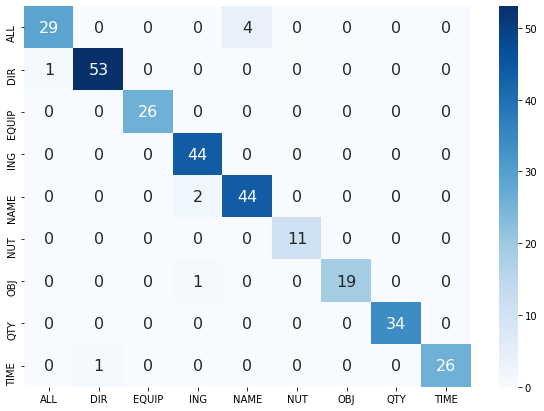

In [26]:
plt.figure(figsize = (10,7))
sn.heatmap(conf_df, annot=True, annot_kws={"size":16}, cmap="Blues")
plt.show()

In [12]:
import matplotlib.pyplot as plt #to generate the t-SNE plot
from sklearn.manifold import TSNE #scikit learn's TSNE 

In [83]:
embedding_clusters = {
    "ALL": [],
    "DIR": [],
    "EQUIP": [],
    "ING": [],
    "NAME": [],
    "NUT": [],
    "OBJ": [],
    "QTY": [],
    "TIME": []
}
labels = []
for emb,label in zip(X_train_vectors,y_train):
    if len(embedding_clusters[label]) < 30:
        labels.append(label)
        embedding_clusters[label].append(emb)

In [84]:
embedding_clusters.keys()

dict_keys(['ALL', 'DIR', 'EQUIP', 'ING', 'NAME', 'NUT', 'OBJ', 'QTY', 'TIME'])

In [85]:
embedding_list = [embedding_clusters[key] for key in embedding_clusters.keys()]

In [86]:
len(embedding_list)

9

In [87]:
embedding_list = np.array(embedding_list)

In [88]:
embedding_list.shape

(9, 30, 300)

In [89]:
n, m, k = embedding_list.shape #geting the dimensions
tsne_model_en_2d = TSNE(perplexity=25, n_components=2, init='pca', n_iter=1500, random_state=2020) 
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_list.reshape(n * m, k))).reshape(n, m, 2) #reshaping it into 2d so we can visualize it

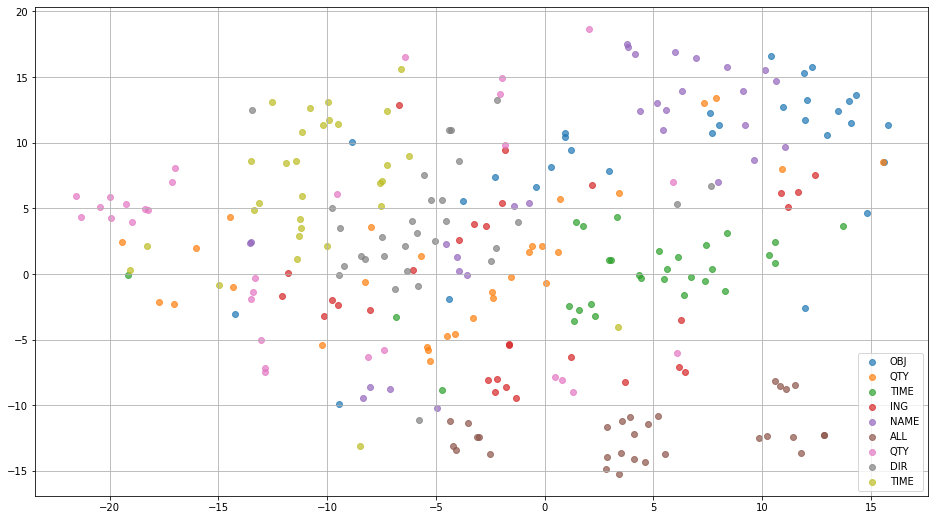

In [90]:
import matplotlib.cm as cm
%matplotlib inline  

#script for constructing two-dimensional graphics using Matplotlib
def tsne_plot_similar_words(labels, embedding_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    

    for label, embeddings in zip(labels, embedding_clusters):
        x = embeddings[:,0]
        y = embeddings[:,1]      
        plt.scatter(x, y, alpha=a, label=label)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(labels, embeddings_en_2d)